In [1]:
import os 
import argparse 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal, Normal, Bernoulli
import torchvision

In [2]:
os.chdir('/Users/chanmunfai/Documents/Imperial/Individual Project//Code_July/Dissertation/')
os.getcwd()


'/Users/chanmunfai/Documents/Imperial/Individual Project/Code_July/Dissertation'

In [3]:
from kvae.modules import KvaeEncoder, Decoder64, DecoderSimple 
from kvae.elbo_loss import ELBO
from kvae.model_kvae import KalmanVAE
from data.MovingMNIST import MovingMNIST
from dataset.bouncing_ball.bouncing_data import BouncingBallDataLoader

In [5]:
train_set = BouncingBallDataLoader('dataset/bouncing_ball/50/train')
train_loader = torch.utils.data.DataLoader(
            dataset=train_set, 
            batch_size=32, 
            shuffle=False)

data, _ = next(iter(train_loader))
print(data.size())

torch.Size([32, 50, 1, 32, 32])


In [19]:
class Args:
  subdirectory = "experiment_bb20"
  dataset = "BouncingBall_50"
  model = 'KVAE'
  alpha = "rnn"
  lstm_layers = 2
  x_dim = 1
  a_dim = 2
  z_dim = 4
  K = 3
  batch_size = 32
  device = "cpu"
  scale = 0.3

args=Args()
kvae = KalmanVAE(args = args).to(args.device)

state_dict_path = "saves/BouncingBall_50/kvae/v2/scale=0.3/scheduler_step=20/kvae_state_dict_scale=0.3_80.pth" 
state_dict = torch.load(state_dict_path, map_location = args.device)
kvae.load_state_dict(state_dict)

<All keys matched successfully>

In [20]:
data, target = next(iter(train_loader))
data = data.to(args.device)
data = (data - data.min()) / (data.max() - data.min())
data = torch.where(data > 0.5, 1.0, 0.0)

target = target.to(args.device)
target = (target - target.min()) / (target.max() - target.min())
target = torch.where(target > 0.5, 1.0, 0.0)

In [21]:
x_predicted, _, _ = kvae.predict(data, 50)

In [43]:
batch_item = 5 # problematic: 3, 4, 5
example_x_predicted = x_predicted[batch_item]

predicted_frames = torchvision.utils.make_grid(
                                        example_x_predicted,
                                        example_x_predicted.size(0)
                                        )

print(predicted_frames.shape)
predicted_frames = predicted_frames.cpu().permute(1, 2, 0).numpy()
print(predicted_frames.shape)

torch.Size([3, 36, 1702])
(36, 1702, 3)


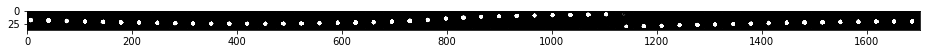

In [44]:
plt.rcParams["figure.figsize"] = (16,12)
plt.imshow(predicted_frames)

# Visualise weights

torch.Size([100, 100, 2])
torch.Size([100, 100, 50])
(100, 100, 3)


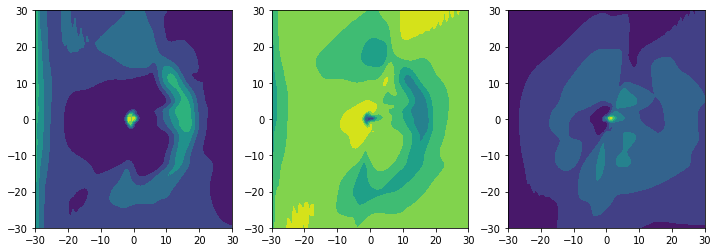

In [64]:
N = 100
xlist = np.linspace(-30, 30, N)
ylist = np.linspace(-30, 30, N)
X, Y = np.meshgrid(xlist, ylist)
X_t = torch.from_numpy(X).unsqueeze(-1)
Y_t = torch.from_numpy(Y).unsqueeze(-1)
dom = torch.cat([X_t,Y_t], dim=-1).float()
print(dom.shape) # BS X T X a_dim 
dyn_emb, _ = kvae.parameter_net(dom) 
print(dyn_emb.shape) # BS X T X 50 
dyn_emb = kvae.alpha_out(dyn_emb.reshape(-1,50))
Z = dyn_emb.softmax(-1).reshape(N,N,-1).detach().numpy()
print(Z.shape) # BS X T X 3 

fig = plt.figure(figsize=(12,4))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    cp = ax.contourf(X, Y, Z[:,:,i])
plt.show()
